In [727]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
import scanpy as sc
import sys
sys.path.insert(0, '/home/olle/PycharmProjects/LODE/feature_segmentation/utils')

import plotting
plt.style.use('seaborn')

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties_naive.csv"
data_pd = pd.read_csv(data_file)

In [728]:
#### add patient id and lateraliy

data_pd["patient_id"] = data_pd.sequence.str.split("_", expand=True)[0]
data_pd["laterality"] = data_pd.sequence.str.split("_", expand=True)[1]

In [729]:
data_pd.head()

,Unnamed: 0,sequence,study_date_1,total_fluid_1,time_range_1,time_range_before_1,time_range_after_1,insertion_type_1,cur_va_rounded_1,next_va_1,...,S1_13_24,S2_13_24,N1_13_24,N2_13_24,C0_13_24,I1_13_24,I2_13_24,Naive,patient_id,laterality
0,0,18_R,2017-10-24,0.001141,NaN,NaN,NaN,NaN,0.40,0.494850,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,18,R
1,1,502_L,2017-07-04,0.002359,NaN,NaN,NaN,NaN,0.30,0.200659,...,0.001228,0.0,0.000000,0.000000,0.001185,0.006170,0.000779,1.0,502,L
2,2,502_R,2016-04-04,0.000534,NaN,NaN,NaN,NaN,0.10,0.494850,...,0.000061,0.0,0.000000,0.000000,0.000340,0.000000,0.000000,NaN,502,R
3,3,709_L,2016-08-08,0.270185,NaN,NaN,NaN,NaN,0.30,0.397940,...,0.062774,0.0,0.146249,0.008603,0.174822,0.000000,0.000000,1.0,709,L
4,4,709_R,2015-11-25,0.716147,NaN,NaN,NaN,NaN,0.89,1.000000,...,0.000000,0.0,0.000000,0.000521,0.000000,0.112738,0.279206,NaN,709,R


In [730]:
data_pd = data_pd.dropna(subset=["Naive"])

print("Number of rows in data frame ", data_pd.shape)

Number of rows in data frame  (405, 500)


In [731]:
data_pd.columns.values

array(['Unnamed: 0', 'sequence', 'study_date_1', 'total_fluid_1',
       'time_range_1', 'time_range_before_1', 'time_range_after_1',
       'insertion_type_1', 'cur_va_rounded_1', 'next_va_1',
       'cumsum_injections_1', 'intra_retinal_fluid_1',
       'sub_retinal_fluid_1', 'srhm_1', 'fibrovascular_ped_1',
       'choroid_1', 'drusen_1', 'rpe_1', 'epiretinal_membrane_1',
       'fibrosis_1', 'T1_3_1', 'T2_3_1', 'S1_3_1', 'S2_3_1', 'N1_3_1',
       'N2_3_1', 'C0_3_1', 'I1_3_1', 'I2_3_1', 'T1_4_1', 'T2_4_1',
       'S1_4_1', 'S2_4_1', 'N1_4_1', 'N2_4_1', 'C0_4_1', 'I1_4_1',
       'I2_4_1', 'T1_5_1', 'T2_5_1', 'S1_5_1', 'S2_5_1', 'N1_5_1',
       'N2_5_1', 'C0_5_1', 'I1_5_1', 'I2_5_1', 'T1_7_1', 'T2_7_1',
       'S1_7_1', 'S2_7_1', 'N1_7_1', 'N2_7_1', 'C0_7_1', 'I1_7_1',
       'I2_7_1', 'T1_10_1', 'T2_10_1', 'S1_10_1', 'S2_10_1', 'N1_10_1',
       'N2_10_1', 'C0_10_1', 'I1_10_1', 'I2_10_1', 'T1_8_1', 'T2_8_1',
       'S1_8_1', 'S2_8_1', 'N1_8_1', 'N2_8_1', 'C0_8_1', 'I1_8_1',
      

In [732]:
##### add delta feature columns

In [733]:
time_points = [6, 12]

features = ["intra_retinal_fluid", 
            "sub_retinal_fluid", 
            "choroid", 
            "drusen", 
            "rpe", 
            "fibrovascular_ped",
            "epiretinal_membrane",
            "srhm", 
            "fibrosis"]

for tp in time_points:
    for feature in features:
        data_pd[f"{feature}_delta_{tp}"] = data_pd[f"{feature}_{tp}"] - data_pd[f"{feature}_{1}"]

#### How many sequence are treated?

In [734]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 405


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

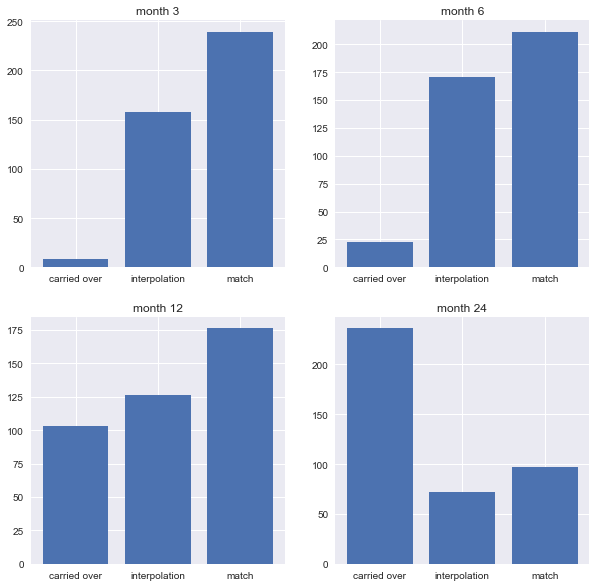

In [735]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

Text(0.5, 1.0, 'Time from carry over 6 months')

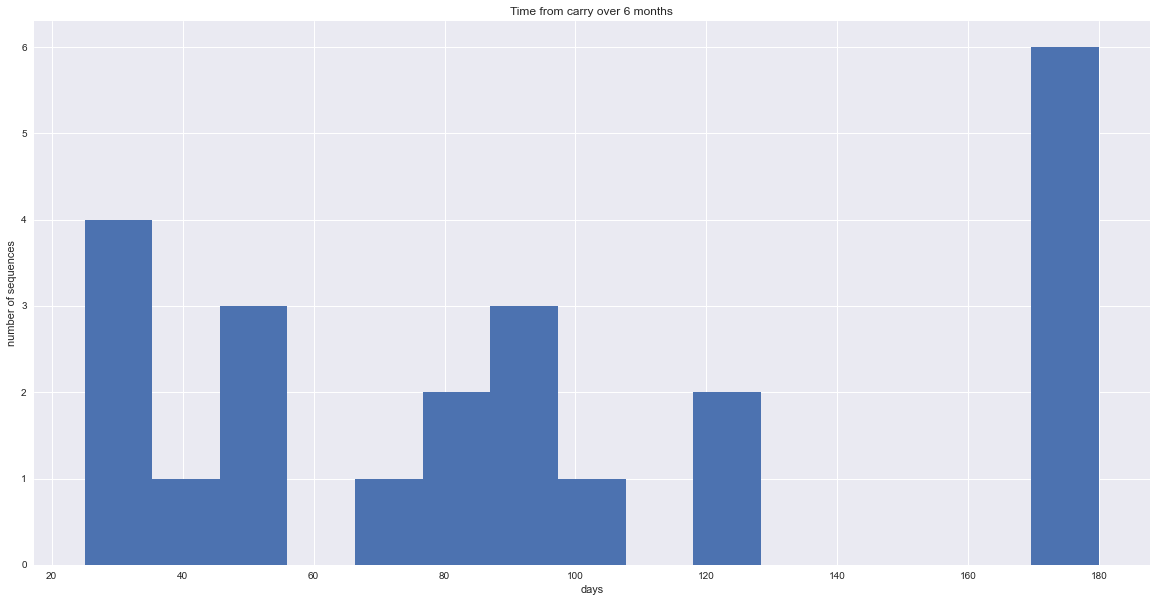

In [736]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

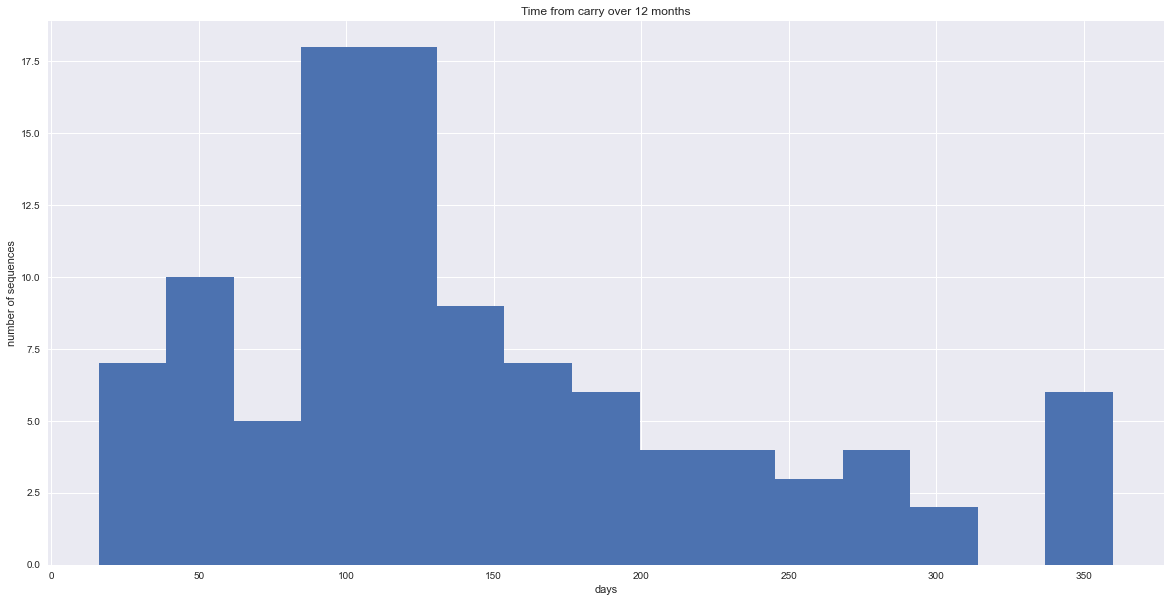

In [737]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

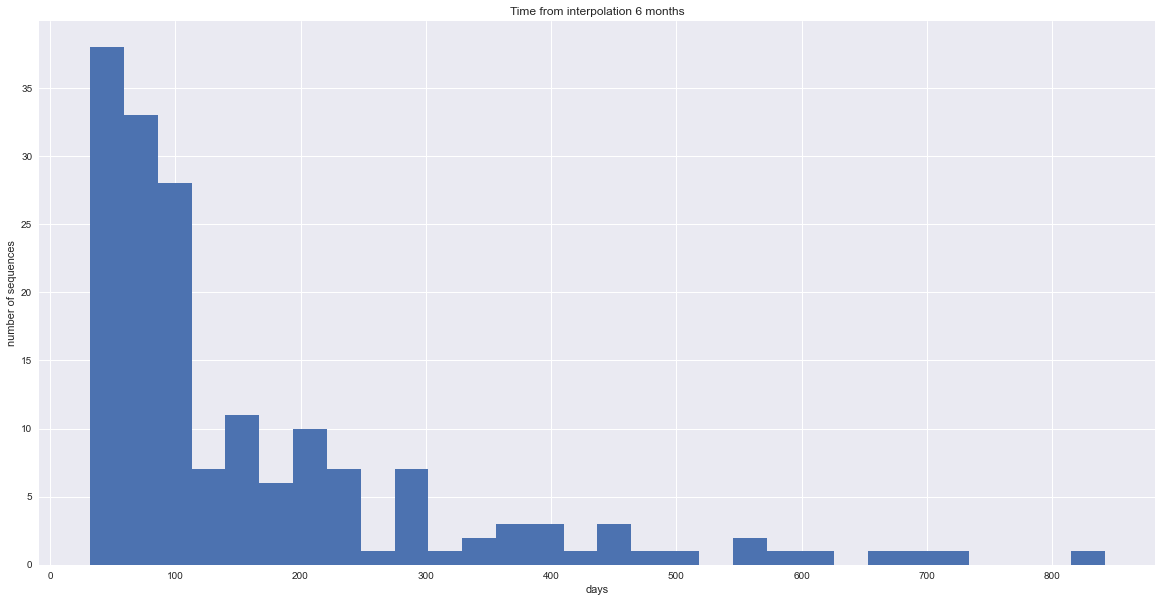

In [738]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

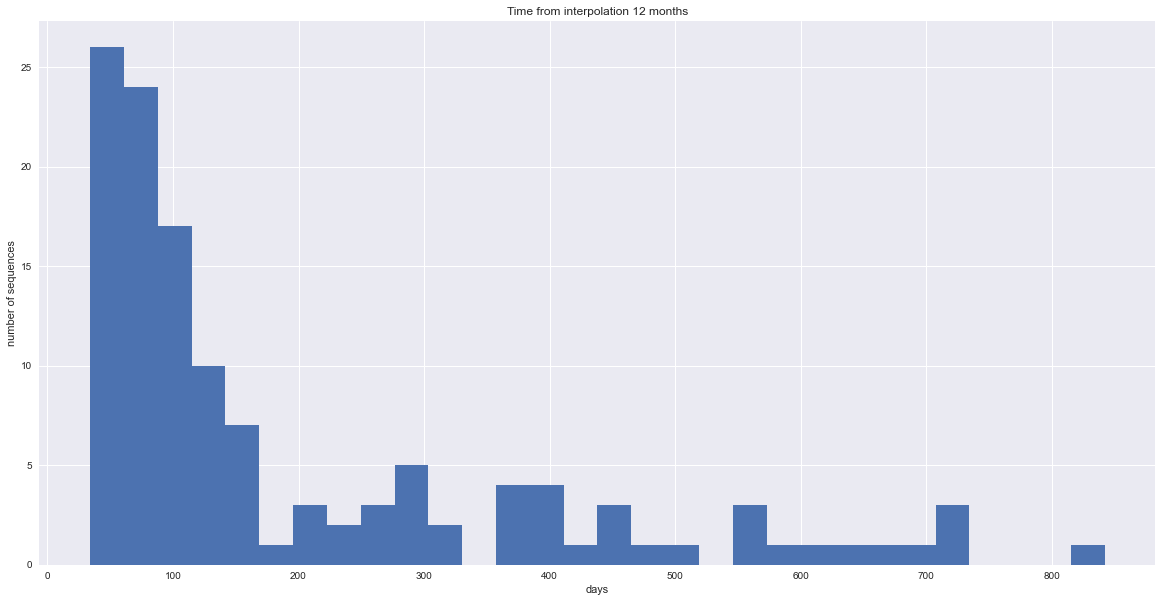

In [739]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [740]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))



Number of sequences starting as dry:  6
Number of sequences dry after 3 months:  8
Number of sequences dry after 6 months:  7
Number of sequences dry after 12 months:  7
Number of sequences dry after 24 months:  14


#### Filter data based on time series eclusion criterias

In [741]:
##### carry over above 2 months

In [742]:
columns = ["time_range_6", "time_range_before_6", "time_range_after_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12",
          "insertion_type_6", "insertion_type_12"]

filter_base = data_pd[columns]

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 


interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match" 

# interpolation time filters
interp_time_before_6 = filter_base.time_range_before_6 < 60
interp_time_after_6 = filter_base.time_range_after_6 < 60

interp_time_before_12 = filter_base.time_range_before_12 < 60
interp_time_after_12 = filter_base.time_range_after_12 < 60

# carry over time filters
carry_over_time_after_6 = filter_base.time_range_6 < 60
carry_over_time_after_12 = filter_base.time_range_12 < 60

In [743]:
# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))

Number of filtered sequences for 6 months are: 295


In [744]:
# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 12 months are: 242


## plot examples

In [745]:
columns = ['patient_id', 'laterality', 'total_fluid_1', 'total_fluid_6', 
           'total_fluid_12', 'cur_va_rounded_1', 'cur_va_rounded_6', 'cur_va_rounded_12']

data_pd[columns]

,patient_id,laterality,total_fluid_1,total_fluid_6,total_fluid_12,cur_va_rounded_1,cur_va_rounded_6,cur_va_rounded_12
0,18,R,0.001141,0.001284,0.002355,0.4,0.260000,0.30
1,502,L,0.002359,0.005640,0.062980,0.3,0.319048,0.40
3,709,L,0.270185,0.077823,0.096735,0.3,0.600000,0.60
5,1263,L,0.002058,0.000147,0.000392,0.4,0.318571,0.49
6,1263,R,0.001133,0.000788,0.006328,0.3,0.267143,0.30
...,...,...,...,...,...,...,...,...
822,359944,R,0.001824,0.001824,0.001824,0.3,0.300000,0.30
823,360270,L,0.077318,0.059745,0.242674,0.4,0.700000,0.70
825,363725,R,0.078402,0.024431,0.024431,0.4,0.600000,0.60
827,365435,L,0.527751,0.138175,0.902346,0.4,0.300000,1.00


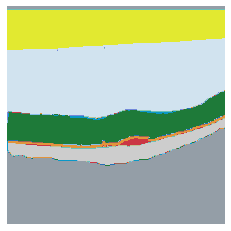

In [746]:
example_path = "/home/olle/PycharmProjects/LODE/workspace/feature_statistics/examples"

patient = "709"
date = "20170809"
laterality = "L"
example_ = os.path.join(example_path, patient, f"{patient}_{laterality}_{date}.npy")

segmentated_oct = np.load(example_)

plotting.plot_image([segmentated_oct[36, :, :]], model_dir="", mode="test", filename="", save_fig=False)

In [747]:
#### visulize oct

(-0.5, 511.5, 495.5, -0.5)

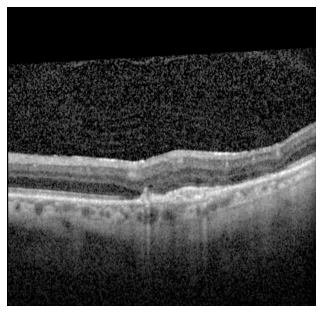

In [748]:
dicom_file = "1.3.6.1.4.1.33437.10.4.4089432.13146752094.27750.4.1.dcm"
dicom = os.path.join(example_path, f"{patient}/Left/{date}", dicom_file) 

vol = read_file(dicom).pixel_array
plt.imshow(np.stack((vol[36, :, :],) * 3, axis=-1))
plt.axis('off')


(0.0, 1.5)

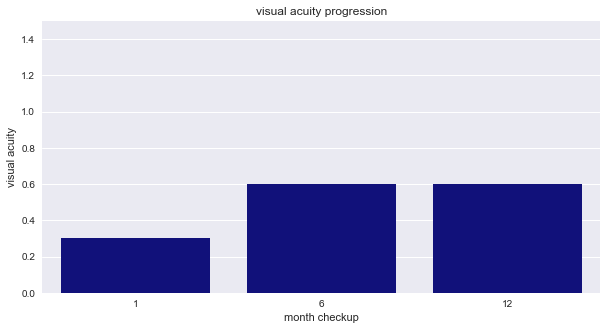

In [749]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=[1, 6, 12], y=[0.3, 0.600000, 0.60], color="darkblue")
#plt.xticks([1, 6, 12])
plt.xlabel("month checkup")
plt.ylabel("visual acuity")
plt.title("visual acuity progression")
plt.ylim([0, 1.5])

## Create Adata objects

In [750]:
feature_columns = ["total_fluid",
"next_va",
"cumsum_injections",
'intra_retinal_fluid',
'sub_retinal_fluid',
'srhm',
'fibrovascular_ped',
'choroid',
'drusen',
'rpe',
'epiretinal_membrane',
'fibrosis']

In [751]:
regions = ["T1", "T2", "S1", "S2", "N1", "N2", "I1", "I2", "C0"]
features = [1, 3, 4, 5, 6, 7, 8, 10, 13]
time_points = [1, 6, 12]

var_names = []
for region in regions:
    for feature in features:
        var_names.append(f"{region}_{feature}_{1}")

## Base line Adata

In [752]:
data_pd = data_pd.dropna(subset=["sequence", "study_date_1"])

X = np.array(data_pd[np.array(var_names)])

obs_id = data_pd["sequence"] + "_" + data_pd["study_date_1"]

va_improved_6 = data_pd.cur_va_rounded_6 - data_pd.cur_va_rounded_1 < 0
va_improved_12 = data_pd.cur_va_rounded_12 - data_pd.cur_va_rounded_1 < 0

adata_baseline = sc.AnnData(X=X)
adata_baseline.obs["obs_id"] = obs_id.values.tolist()
adata_baseline.obs["obs_va_6_improved"] = va_improved_6.astype(int).values.tolist()
adata_baseline.obs["obs_va_12_improved"] = va_improved_12.astype(int).values.tolist()

adata_baseline.obs["va_delta_6"] = pd.DataFrame(data_pd.cur_va_rounded_6 - data_pd.cur_va_rounded_1)[0].values
adata_baseline.obs["va_delta_12"] = pd.DataFrame(data_pd.cur_va_rounded_12 - data_pd.cur_va_rounded_1)[0].values

data_pd["cumsum_injections_1"] = data_pd.cumsum_injections_1.fillna(0)
data_pd["cumsum_injections_6"] = data_pd.cumsum_injections_6.fillna(0)
data_pd["cumsum_injections_12"] = data_pd.cumsum_injections_12.fillna(0)

adata_baseline.obs["cumsum_injections_1"] = data_pd.cumsum_injections_1.values
adata_baseline.obs["cumsum_injections_6"] = data_pd.cumsum_injections_6.values
adata_baseline.obs["cumsum_injections_12"] = data_pd.cumsum_injections_12.values

adata_baseline.obs["obs_va_1"] = data_pd.cur_va_rounded_1.values.tolist()
adata_baseline.obs["obs_va_6"] = data_pd.cur_va_rounded_6.values.tolist()
adata_baseline.obs["obs_va_12"] = data_pd.cur_va_rounded_12.values.tolist()

for region in regions:
    for feature in features:
        for time_point in [1, 6, 12]:
            var_ = f"{region}_{feature}_{time_point}"
            adata_baseline.obs[var_] = data_pd[var_].values.tolist()

for feature in feature_columns:
    for time_point in [1, 6, 12]:
            var_ = f"{feature}_{time_point}"
            adata_baseline.obs[var_] = data_pd[var_].values.tolist()
    
adata_baseline.obs["naive"] = data_pd.Naive.values.tolist()
adata_baseline.var["var_name"] = var_names

### Basic statistics

In [753]:
adata.obs.columns

print(f"Base line mean BCVA {np.mean(adata_baseline.obs.obs_va_1)} +- {np.std(adata_baseline.obs.obs_va_1)}")
print(f"6 month mean BCVA {np.mean(adata_baseline.obs.obs_va_6)} +- {np.std(adata_baseline.obs.obs_va_6)}")
print(f"12 month mean BCVA {np.mean(adata_baseline.obs.obs_va_12)} +- {np.std(adata_baseline.obs.obs_va_12)}")

Base line mean BCVA 0.5815061728395061 +- 0.40756119357110776
6 month mean BCVA 0.5287700137739807 +- 0.37111160962186923
12 month mean BCVA 0.5600698016495445 +- 0.40787662428470745


In [754]:
print(f"6 month mean BCVA change {np.mean(adata_baseline.obs.va_delta_6)} +- {np.std(adata_baseline.obs.va_delta_6)}")
print(f"12 month mean BCVA change {np.mean(adata_baseline.obs.va_delta_12)} +- {np.std(adata_baseline.obs.va_delta_12)}")

6 month mean BCVA change -0.05273615906552552 +- 0.2791332891612797
12 month mean BCVA change -0.021436371189961695 +- 0.3046837314740241


In [755]:
print(f"6 month average # injections {np.mean(adata_baseline.obs.cumsum_injections_6)} +- {np.std(adata_baseline.obs.cumsum_injections_6)}")
print(f"12 month average # injections {np.mean(adata_baseline.obs.cumsum_injections_12)} +- {np.std(adata_baseline.obs.cumsum_injections_12)}")

6 month average # injections 4.280285346852002 +- 1.9038896337679994
12 month average # injections 6.242259314287342 +- 2.929484921137151


In [756]:
for feature in feature_columns:
    for time_point in [1, 6, 12]:
            var_ = f"{feature}_{time_point}"
            stat_str = f"mean {np.round(np.mean(adata_baseline.obs[var_]), 2)} +- {np.round(np.std(adata_baseline.obs[var_]), 2)}"
            print(f"{time_point} month recording of {var_}: {stat_str}")

1 month recording of total_fluid_1: mean 0.16 +- 0.3
6 month recording of total_fluid_6: mean 0.07 +- 0.23
12 month recording of total_fluid_12: mean 0.07 +- 0.31
1 month recording of next_va_1: mean 0.55 +- 0.39
6 month recording of next_va_6: mean 0.55 +- 0.4
12 month recording of next_va_12: mean 0.55 +- 0.42
1 month recording of cumsum_injections_1: mean 1.4 +- 0.96
6 month recording of cumsum_injections_6: mean 4.28 +- 1.9
12 month recording of cumsum_injections_12: mean 6.24 +- 2.93
1 month recording of intra_retinal_fluid_1: mean 0.06 +- 0.16
6 month recording of intra_retinal_fluid_6: mean 0.04 +- 0.2
12 month recording of intra_retinal_fluid_12: mean 0.04 +- 0.25
1 month recording of sub_retinal_fluid_1: mean 0.11 +- 0.22
6 month recording of sub_retinal_fluid_6: mean 0.03 +- 0.09
12 month recording of sub_retinal_fluid_12: mean 0.04 +- 0.1
1 month recording of srhm_1: mean 0.03 +- 0.06
6 month recording of srhm_6: mean 0.02 +- 0.04
12 month recording of srhm_12: mean 0.02 +- 

## Regression analysis

In [ ]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

In [757]:
## plot distributions

/home/olle/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/olle/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


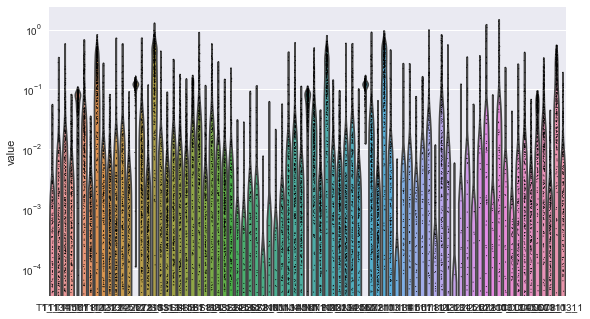

In [758]:
sc.pl.violin(adata_baseline, var_names, log=True)

In [759]:
## normalize data

In [761]:
adata_baseline.var

,var_name
0,T1_1_1
1,T1_3_1
2,T1_4_1
3,T1_5_1
4,T1_6_1
...,...
76,C0_6_1
77,C0_7_1
78,C0_8_1
79,C0_10_1


In [762]:
sc.pp.normalize_total(adata_baseline, target_sum=1, inplace=True)
adata_baseline.obs["T1_3_1"]

0      0.000037
1      0.000032
2      0.000000
3      0.000000
4      0.000000
         ...   
400    0.000179
401    0.023848
402    0.000058
403    0.005592
404    0.010571
Name: T1_3_1, Length: 405, dtype: float64

In [675]:
## PCA analysis

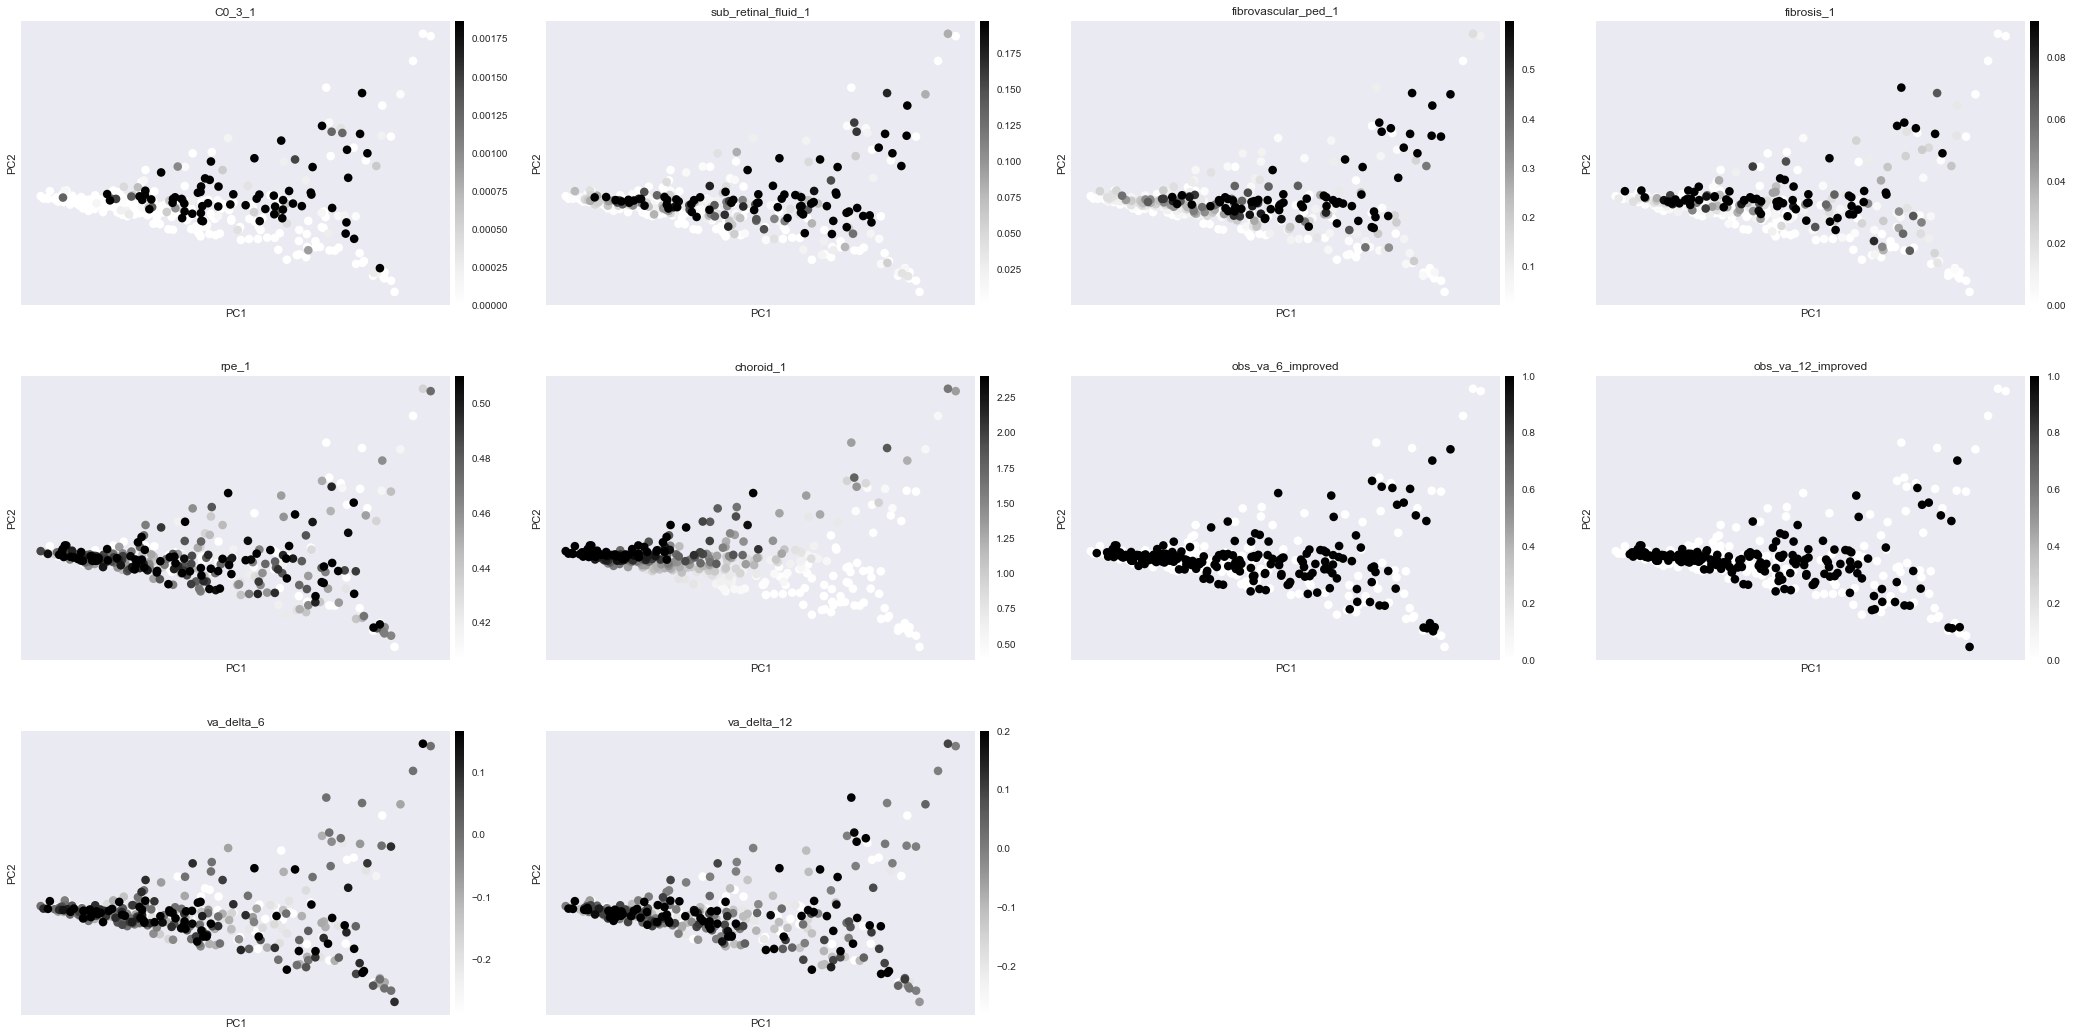

In [799]:
sc.tl.pca(adata_baseline, n_comps=10, svd_solver='arpack')
sc.pl.pca(adata_baseline, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved', "va_delta_6", "va_delta_12"],
          vmax='p85', vmin='p15')


In [678]:
## unsupervised learning on data

<Figure size 1440x720 with 0 Axes>

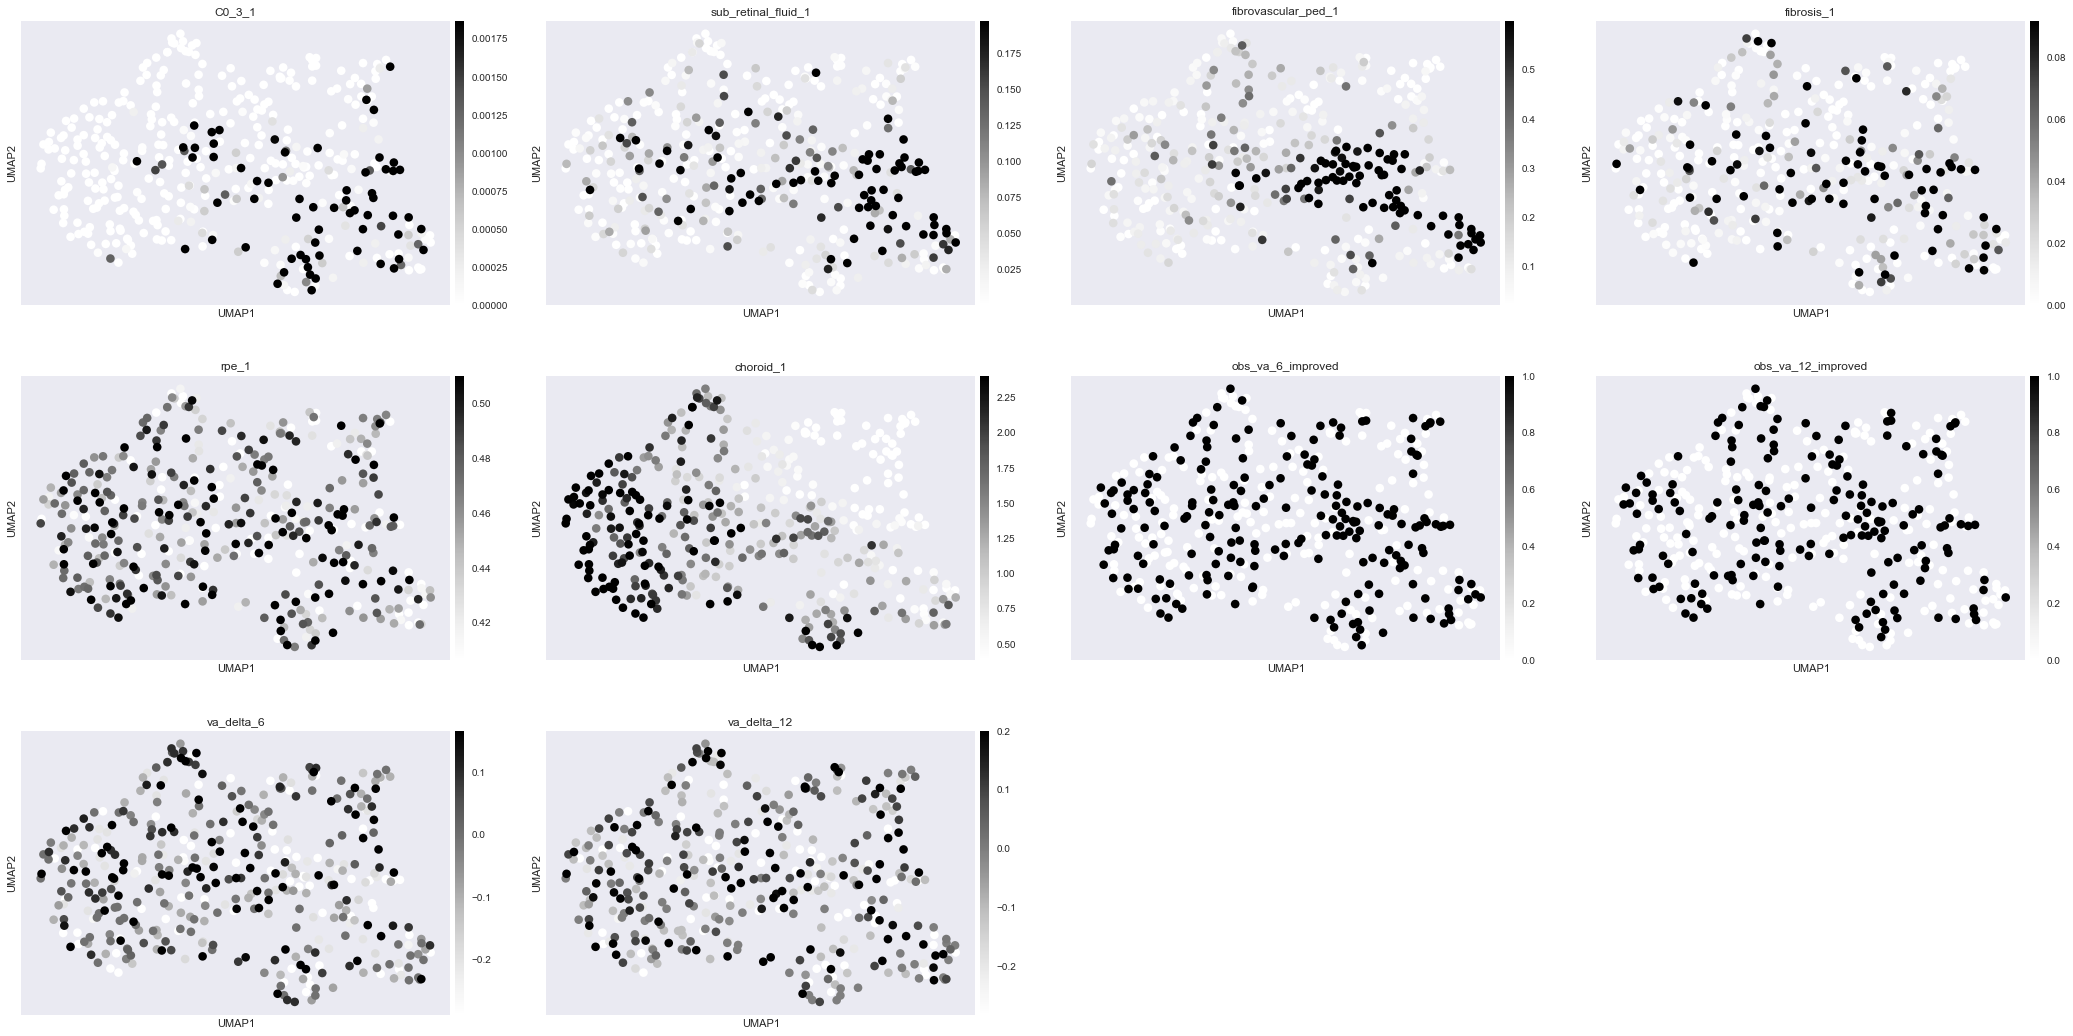

In [798]:
sc.pp.neighbors(adata_baseline, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata_baseline)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_baseline, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"], vmax='p85', vmin='p15')

In [680]:
adata_va_delta_filtered = adata[np.abs(adata_baseline.obs.va_delta_6) > 0.15]

<Figure size 1440x720 with 0 Axes>

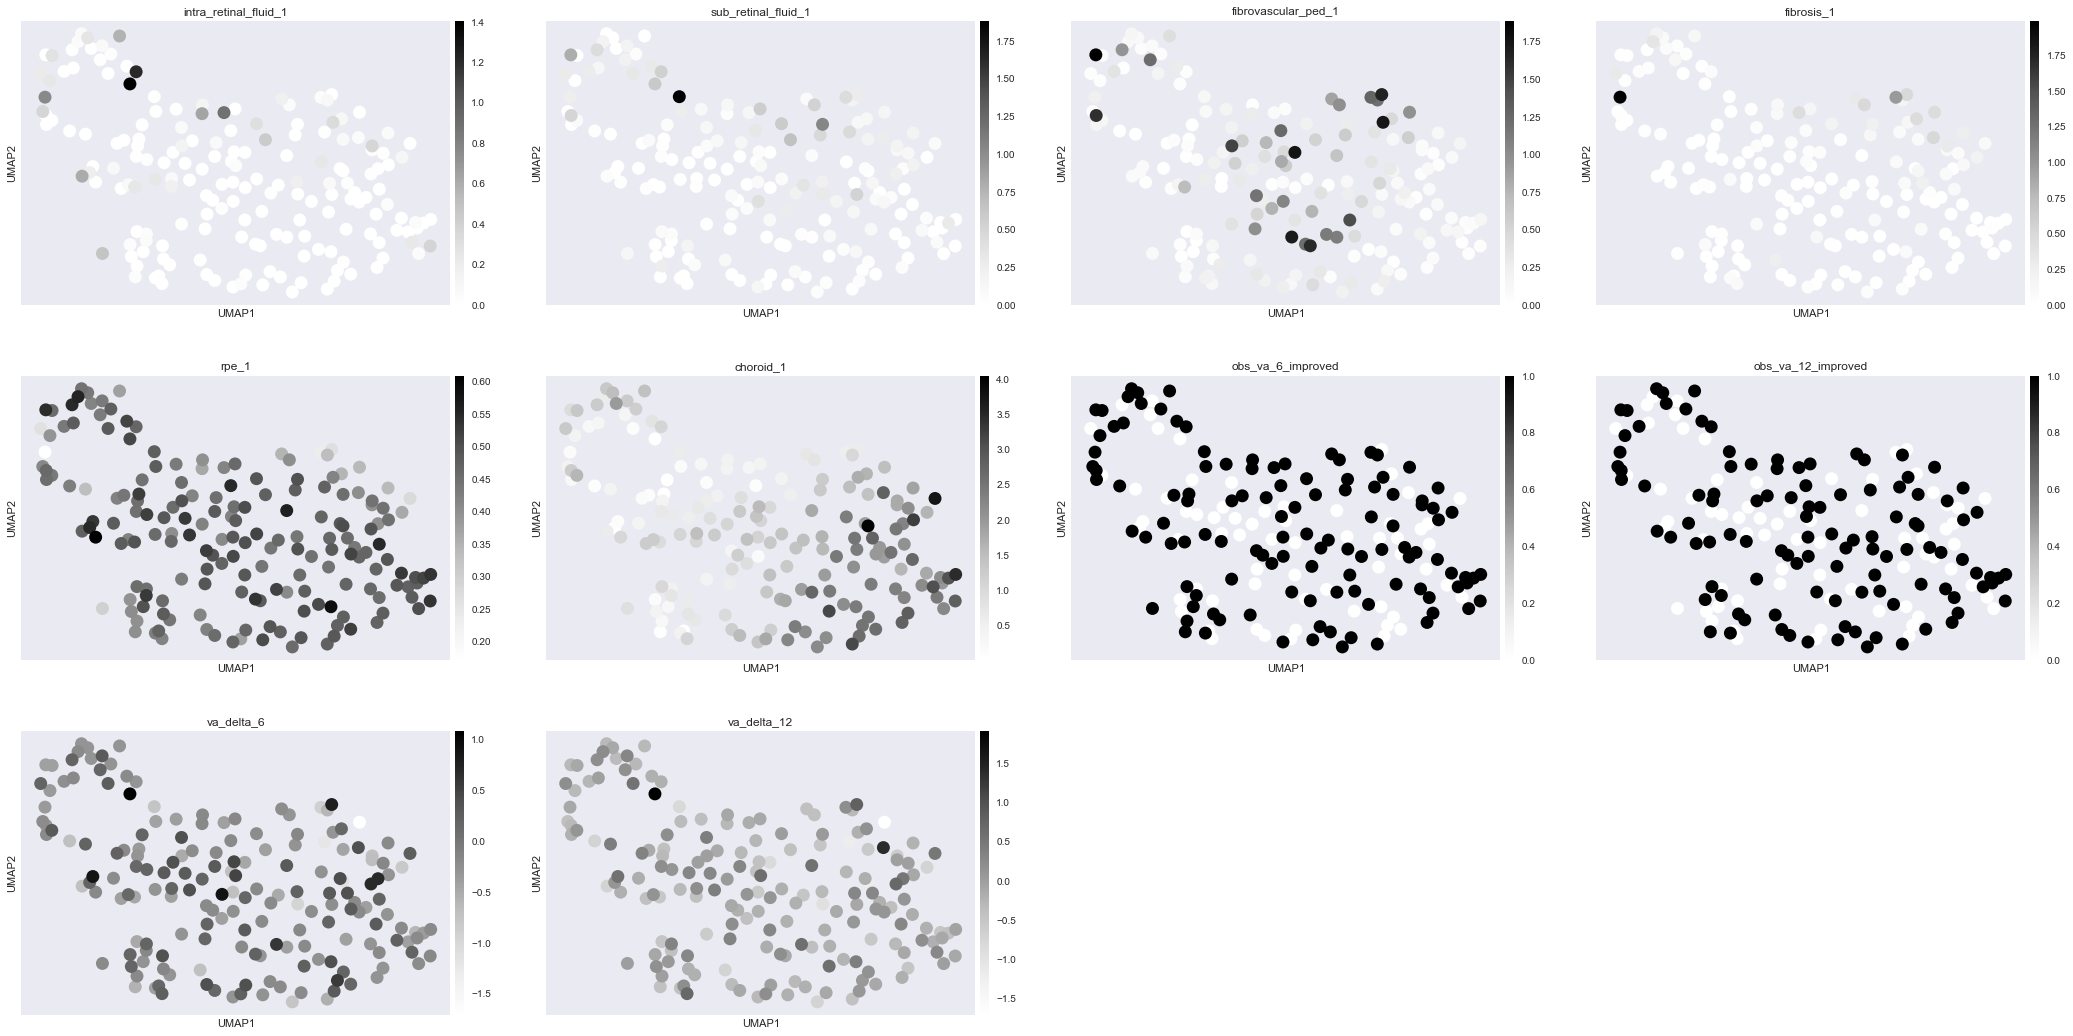

In [681]:
sc.pp.neighbors(adata_va_delta_filtered, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_va_delta_filtered)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_va_delta_filtered, color=['intra_retinal_fluid_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"])

### 6 month Adata

In [789]:
X_dict = {}
for region in regions:
    for feature in features:
        var_ = f"{region}_{feature}_{16}_delta"
        var_1 = f"{region}_{feature}_{1}"
        var_6 = f"{region}_{feature}_{6}"

        X_dict[var_] = data_pd[var_1].values - data_pd[var_6].values

In [790]:
delta_six_month_pd = pd.DataFrame(X_dict)

var_names = delta_six_month_pd.columns.tolist()

X = np.array(delta_six_month_pd[np.array(var_names)])

adata_six_month = sc.AnnData(X=X)
adata_six_month.var_names = var_names
adata_six_month.obs = adata_baseline.obs

/home/olle/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/olle/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


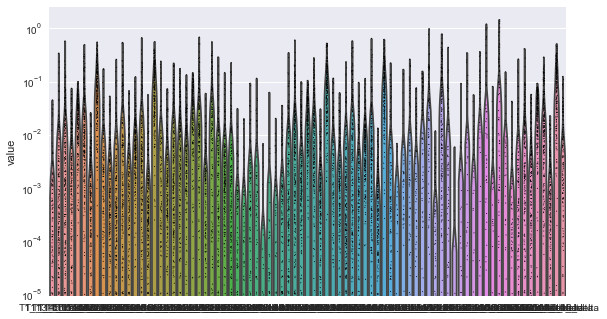

In [791]:
sc.pl.violin(adata_six_month, var_names, log=True)

In [787]:
sc.pp.normalize_total(adata_six_month, target_sum=1, inplace=True)

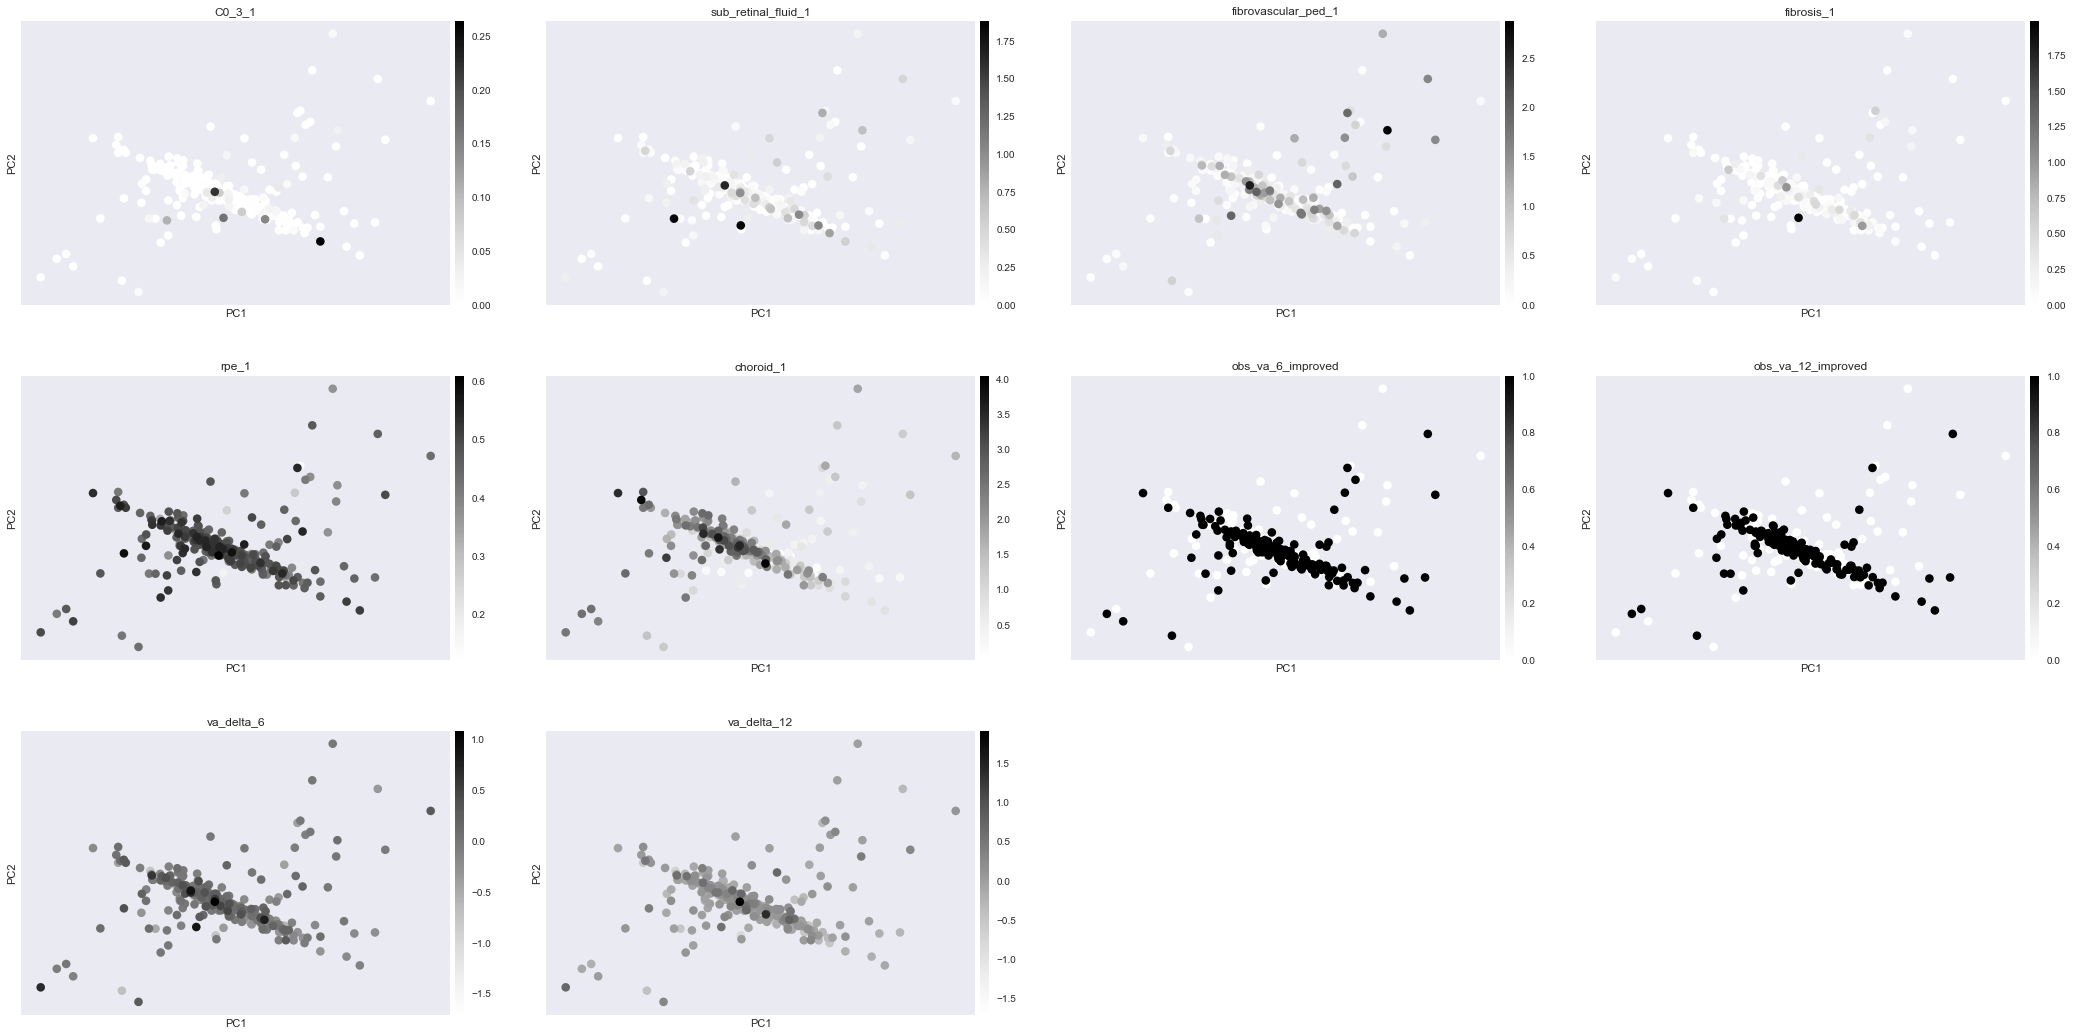

In [792]:
sc.tl.pca(adata_six_month, n_comps=10, svd_solver='arpack')
sc.pl.pca(adata_six_month, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved', "va_delta_6", "va_delta_12"])


<Figure size 1440x720 with 0 Axes>

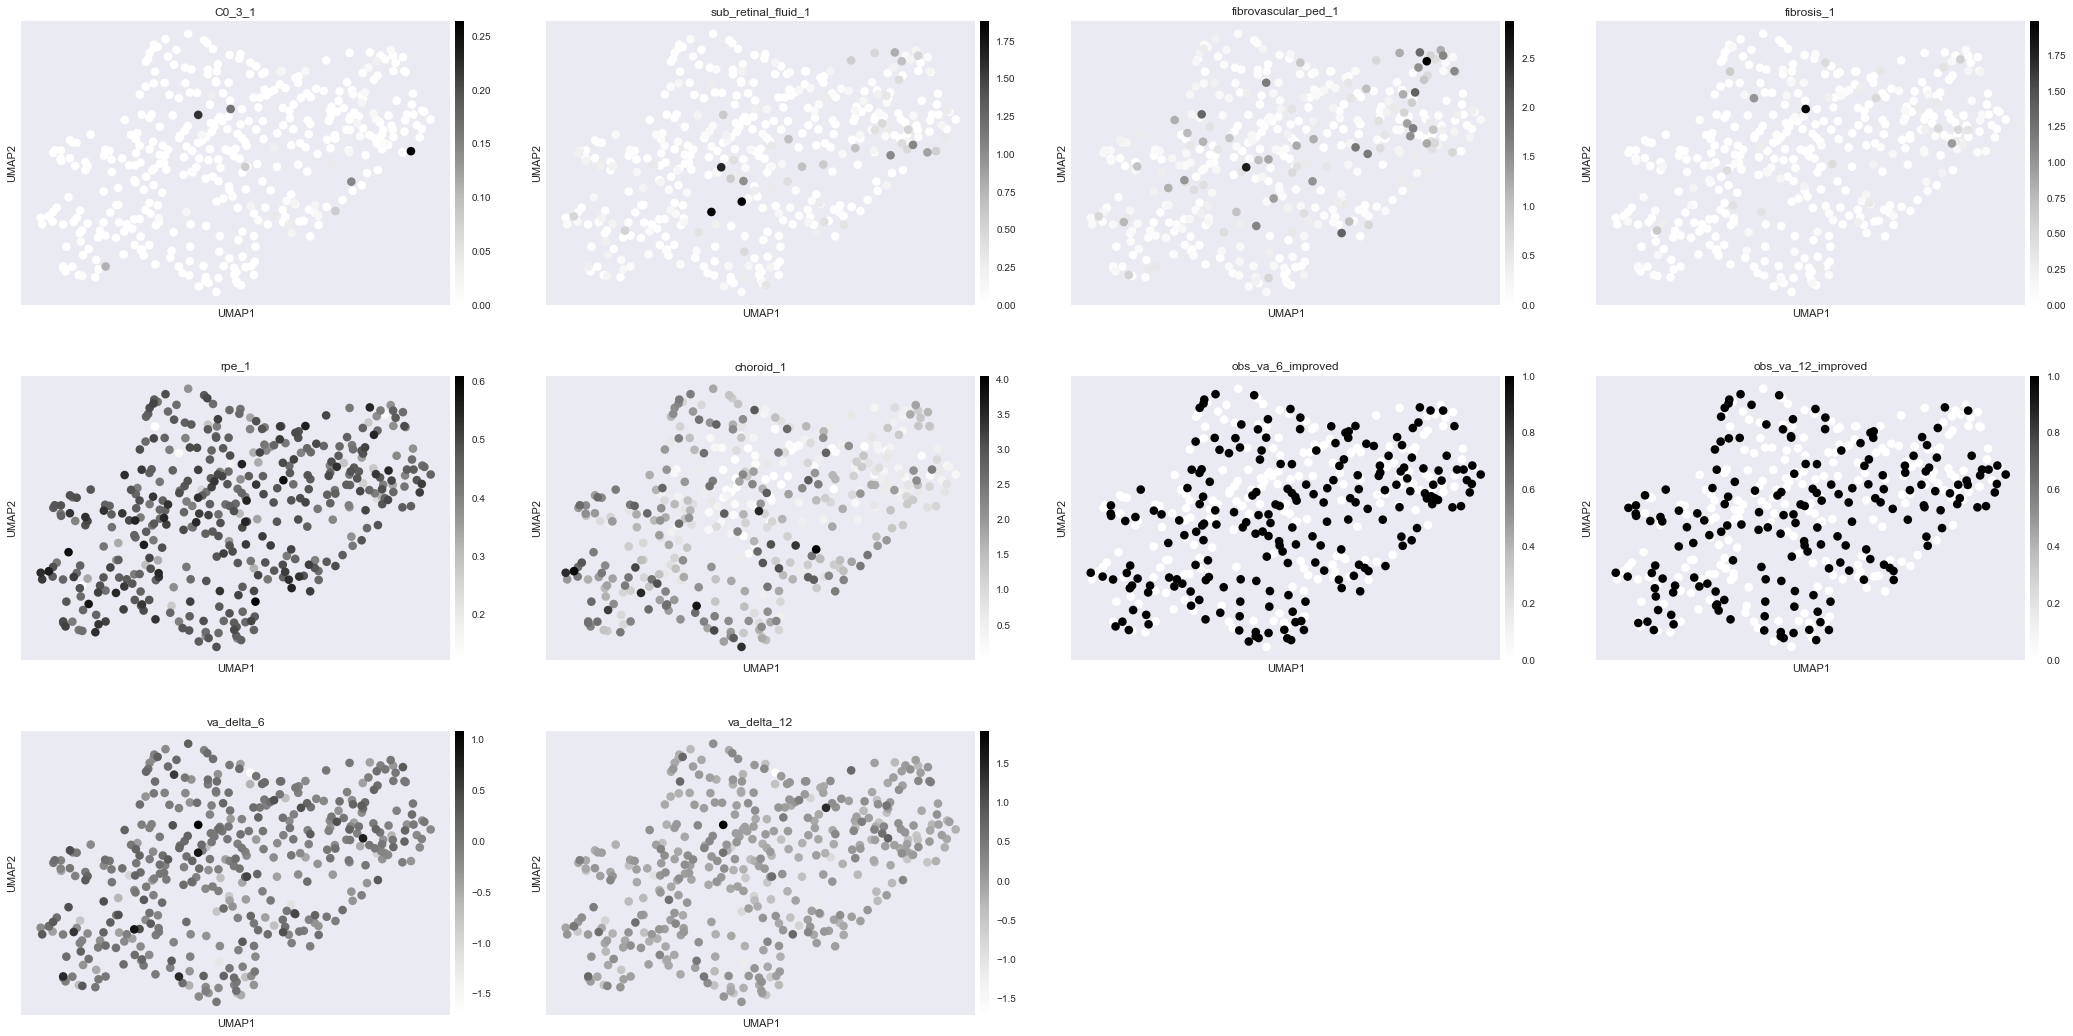

In [793]:
sc.pp.neighbors(adata_six_month, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata_six_month)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_six_month, color=['C0_3_1', 'sub_retinal_fluid_1', 
                         'fibrovascular_ped_1', 'fibrosis_1', "rpe_1", "choroid_1",
                         'obs_va_6_improved', 'obs_va_12_improved',
                         "va_delta_6", "va_delta_12"])

#### Define VA fate groups

In [23]:
#### Worsened v. Imporoved

In [31]:
data_6 = data_pd.loc[filter_6]
data_12 = data_pd.loc[filter_12]

In [32]:
print("Number of patients in 6 month cohort:", data_6.patient_id.drop_duplicates().shape[0])
print("Number of patients in 12 month cohort:", data_12.patient_id.drop_duplicates().shape[0])

Number of patients in 6 month cohort: 229
Number of patients in 12 month cohort: 187


In [33]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_month_recovery"] = va_delta_6 <= 0
data_12["twelwe_month_recovery"] = va_delta_12 <= 0

print("six month recovery: ", sum(data_6["six_month_recovery"]))
print("twelwe month recovery: ", sum(data_12["twelwe_month_recovery"]))

six month recovery:  170
twelwe month recovery:  123


/home/olle/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/olle/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
#### Considerably worsened v. Imporoved

In [28]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_consid_month_recovery"]= "no change"
data_6["six_consid_month_recovery"][va_delta_6 <= -0.15] = "improved"
data_6["six_consid_month_recovery"][va_delta_6 >= 0.15] = "worsened"

data_12["twelwe_consid_month_recovery"]= "no change"
data_12["twelwe_consid_month_recovery"][va_delta_12 <= -0.15] = "improved"
data_12["twelwe_consid_month_recovery"][va_delta_12 >= 0.15] = "worsened"

print(np.unique(data_6["six_consid_month_recovery"], return_counts=True))
print(np.unique(data_12["twelwe_consid_month_recovery"], return_counts=True))

(array(['improved', 'no change', 'worsened'], dtype=object), array([ 78, 138,  47]))
(array(['improved', 'no change', 'worsened'], dtype=object), array([ 54, 116,  44]))


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [29]:
### Improved from VI to NVI

In [30]:
vi6_1 = data_6.cur_va_rounded_1 >= 0.4 
nvi_6 = data_6.cur_va_rounded_6 < 0.4

vi12_1 = data_12.cur_va_rounded_1 >= 0.4 
nvi_12 = data_12.cur_va_rounded_12 < 0.4 

data_6["six_month_vi_recovery"] = np.logical_and(vi6_1.values, nvi_6.values)
data_12["twelwe_month_vi_recovery"] = np.logical_and(vi12_1.values, nvi_12.values)

print("six month vi recovery: ", sum(data_6["six_month_vi_recovery"]))
print("twelwe month vi recovery: ", sum(data_12["twelwe_month_vi_recovery"]))

six month vi recovery:  36
twelwe month vi recovery:  31


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
### Improved from LB to NLB

In [32]:
lb6_1 = data_6.cur_va_rounded_1 >= 1.0
nlb_6 = data_6.cur_va_rounded_6 < 1.0 

lb12_1 = data_12.cur_va_rounded_1 >= 1.0
nlb_12 = data_12.cur_va_rounded_12 < 1.0 

data_6["six_month_lb_recoverment"] = np.logical_and(lb6_1.values, nlb_6.values)
data_12["twelwe_month_lb_recoverment"] = np.logical_and(lb12_1.values, nlb_12.values)

print("six month lb recoverment: ", sum(data_6["six_month_lb_recoverment"]))
print("twelwe month lb recoverment: ", sum(data_12["twelwe_month_lb_recoverment"]))


six month lb recoverment:  23
twelwe month lb recoverment:  20


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## linear mixed effect modeling

In [33]:
data_6.columns.values

data_6.six_month_recovery



5       True
8       True
9      False
12      True
14     False
       ...  
368    False
371    False
372    False
373     True
374     True
Name: six_month_recovery, Length: 263, dtype: bool

### VA outcome distribution plotting

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
sns.set_theme(style="whitegrid")

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'Normalized feature distribution')

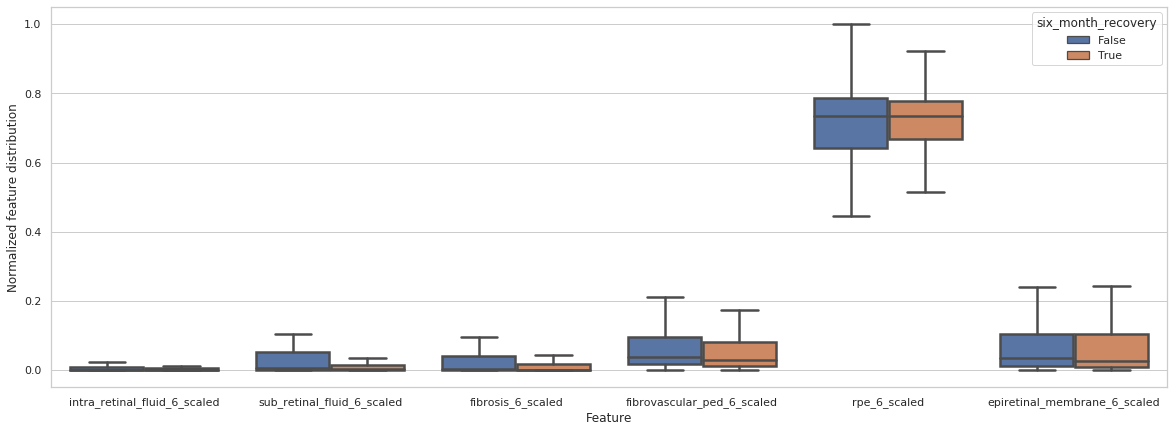

In [35]:
#### six month outcome
value_columns = ["intra_retinal_fluid_6", "sub_retinal_fluid_6", "fibrosis_6", 
          "fibrovascular_ped_6", "rpe_6", "epiretinal_membrane_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_6_scaled", 
                        "sub_retinal_fluid_6_scaled", "fibrosis_6_scaled", 
                        "fibrovascular_ped_6_scaled", "rpe_6_scaled", 
                        "epiretinal_membrane_6_scaled"]


data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns_scaled)

data_6_plotting = data_6_plotting.loc[data_6_plotting.value.values != 1.000]

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

plt.xlabel("Feature")
plt.ylabel("Normalized feature distribution")

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

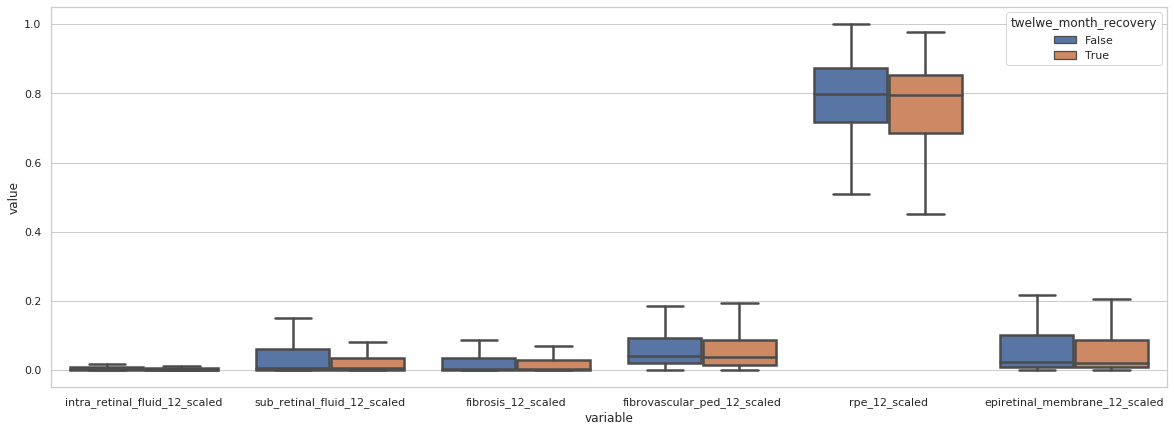

In [36]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_12", "sub_retinal_fluid_12", "fibrosis_12", 
          "fibrovascular_ped_12", "rpe_12", "epiretinal_membrane_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_12_scaled", 
                        "sub_retinal_fluid_12_scaled", "fibrosis_12_scaled", 
                        "fibrovascular_ped_12_scaled", "rpe_12_scaled", 
                        "epiretinal_membrane_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns_scaled)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)

In [37]:
data_12.columns.values

array(['Unnamed: 0', 'patient_id', 'laterality', 'first_injection_date',
       'Naive', 'sequence', 'Unnamed: 0.1', 'study_date_1',
       'total_fluid_1', 'time_range_1', 'time_range_before_1',
       'time_range_after_1', 'insertion_type_1', 'cur_va_rounded_1',
       'next_va_1', 'intra_retinal_fluid_1', 'sub_retinal_fluid_1',
       'srhm_1', 'fibrovascular_ped_1', 'choroid_1', 'drusen_1', 'rpe_1',
       'epiretinal_membrane_1', 'fibrosis_1', 'study_date_3',
       'total_fluid_3', 'time_range_3', 'time_range_before_3',
       'time_range_after_3', 'insertion_type_3', 'cur_va_rounded_3',
       'next_va_3', 'intra_retinal_fluid_3', 'sub_retinal_fluid_3',
       'srhm_3', 'fibrovascular_ped_3', 'choroid_3', 'drusen_3', 'rpe_3',
       'epiretinal_membrane_3', 'fibrosis_3', 'study_date_6',
       'total_fluid_6', 'time_range_6', 'time_range_before_6',
       'time_range_after_6', 'insertion_type_6', 'cur_va_rounded_6',
       'next_va_6', 'intra_retinal_fluid_6', 'sub_retinal_fluid

#### Plotting delta values

Text(0, 0.5, 'delta (mm3)')

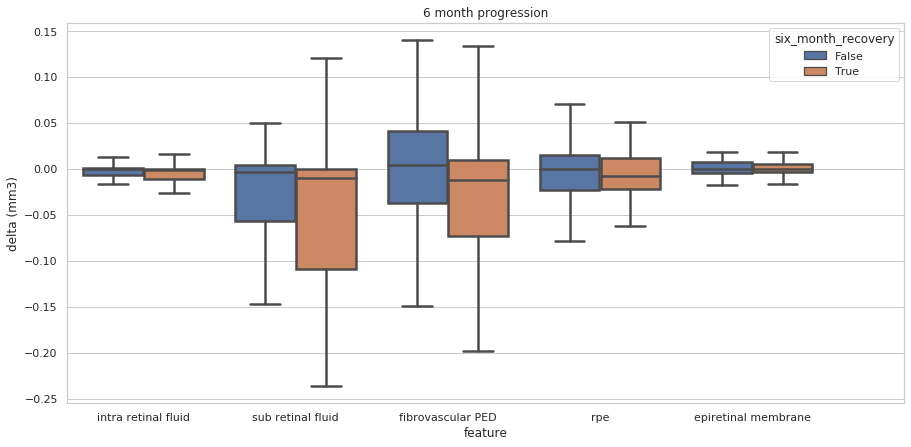

In [129]:
#### 6 month outcome
value_columns = ["intra_retinal_fluid_delta_6", "sub_retinal_fluid_delta_6", 
          "fibrovascular_ped_delta_6", "rpe_delta_6", "epiretinal_membrane_delta_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_6_scaled", "sub_retinal_fluid_delta_6_scaled", 
                        "fibrovascular_ped_delta_6_scaled", 
                        "rpe_delta_6_scaled", "epiretinal_membrane_delta_6_scaled"]

data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])


plt.title("6 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'delta (mm3)')

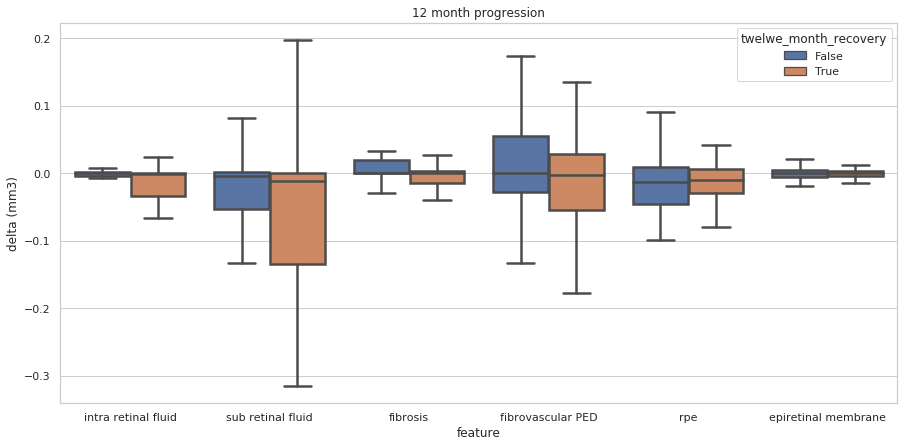

In [39]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_12", "sub_retinal_fluid_delta_12", "fibrosis_delta_12", 
          "fibrovascular_ped_delta_12", "rpe_delta_12", "epiretinal_membrane_delta_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_12_scaled", "sub_retinal_fluid_delta_12_scaled", 
                        "fibrosis_delta_12_scaled", "fibrovascular_ped_delta_12_scaled", 
                        "rpe_delta_12_scaled", "epiretinal_membrane_delta_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)


ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])

plt.title("12 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")

### Cases with considerable recovery or worsening

In [40]:
print(np.unique(data_6["six_consid_month_recovery"], return_counts=True))
print(np.unique(data_12["twelwe_consid_month_recovery"], return_counts=True))

(array(['improved', 'no change', 'worsened'], dtype=object), array([ 78, 138,  47]))
(array(['improved', 'no change', 'worsened'], dtype=object), array([ 54, 116,  44]))


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'delta (mm3)')

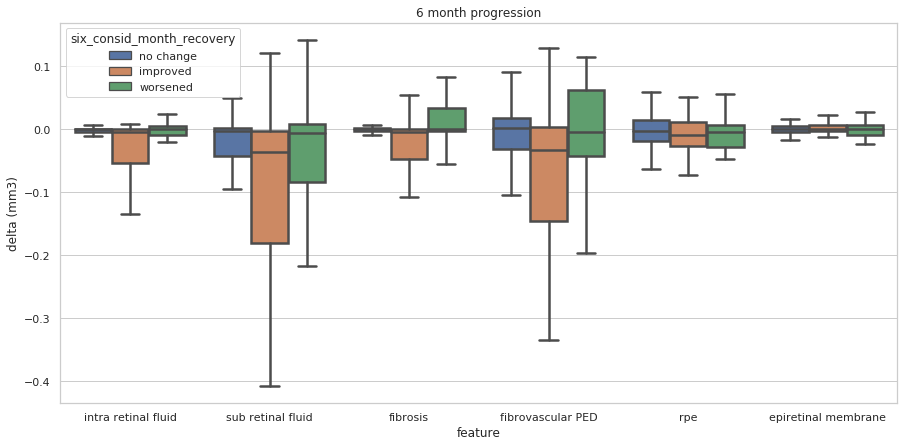

In [41]:
#### 6 month outcome
value_columns = ["intra_retinal_fluid_delta_6", "sub_retinal_fluid_delta_6", "fibrosis_delta_6", 
          "fibrovascular_ped_delta_6", "rpe_delta_6", "epiretinal_membrane_delta_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_6_scaled", "sub_retinal_fluid_delta_6_scaled", 
                        "fibrosis_delta_6_scaled", "fibrovascular_ped_delta_6_scaled", 
                        "rpe_delta_6_scaled", "epiretinal_membrane_delta_6_scaled"]

data_6_plotting = pd.melt(data_6, id_vars=["six_consid_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="six_consid_month_recovery",
                 data=data_6_plotting, linewidth=2.5, showfliers=False)

ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])


plt.title("6 month progression")

plt.xlabel("feature")
plt.ylabel("delta (mm3)")


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'delta (mm3)')

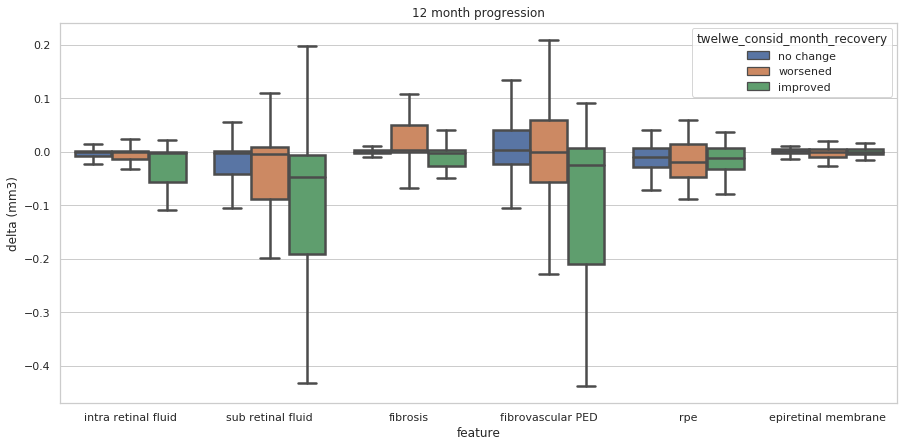

In [42]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_12", "sub_retinal_fluid_delta_12", "fibrosis_delta_12", 
          "fibrovascular_ped_delta_12", "rpe_delta_12", "epiretinal_membrane_delta_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_12_scaled", "sub_retinal_fluid_delta_12_scaled", 
                        "fibrosis_delta_12_scaled", "fibrovascular_ped_delta_12_scaled", 
                        "rpe_delta_12_scaled", "epiretinal_membrane_delta_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_consid_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(15,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_consid_month_recovery",
                 data=data_12_plotting, linewidth=2.5, showfliers=False)


ax.set_xticks(range(6))
ax.set_xticklabels(["intra retinal fluid", "sub retinal fluid", "fibrosis", "fibrovascular PED", 
                    "rpe", "epiretinal membrane"])

plt.title("12 month progression")
plt.xlabel("feature")
plt.ylabel("delta (mm3)")